In [62]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from anndata import AnnData
import squidpy as sq
import scanpy as sc
from cellpose import models, io
import matplotlib.pyplot as plt
from modest_image import ModestImage, imshow
from skimage.restoration import inpaint
#%matplotlib widget
import cv2
import torch
from skimage import io, morphology
import skimage.feature as features
from scipy import ndimage
import time
from tqdm.notebook import tqdm
import scipy
import seaborn as sns

import skimage
from skimage.measure import regionprops, regionprops_table, approximate_polygon
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
import geopandas
import scanpy as sc
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon
import matplotlib
from matplotlib.colors import Normalize


import pipelineScripts as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
name_slide='A1-1'
path_Coordinates='/srv/scratch/lottep/20272_slide1_submission/data_complete/20272_slide1_'+name_slide+'_results.txt'
path_image="/srv/scratch/lottep/RESOLVE/Data_Martin/DAPI_stains/Montage_"+name_slide+".tif"

In [3]:
path='/srv/scratch/lottep/20272_slide1_submission/DAPI_stains/20272_slide1_A1-1_DAPI.tiff'

In [4]:
ugly_Im=io.imread(path)

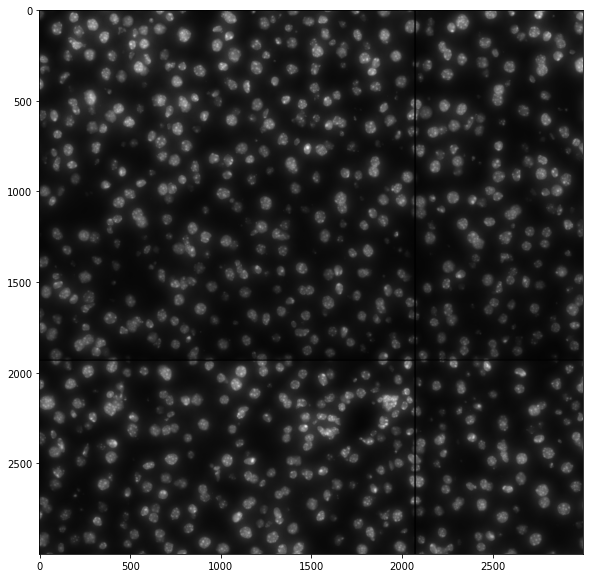

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(ugly_Im[4500:7500,6500:9500],cmap='gray')

22.63489055633545


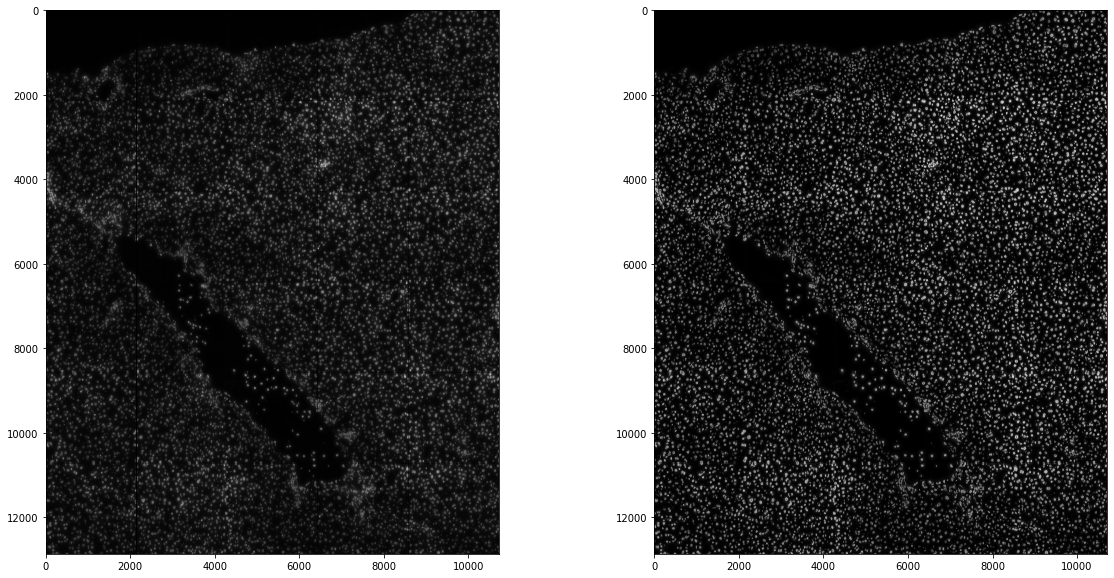

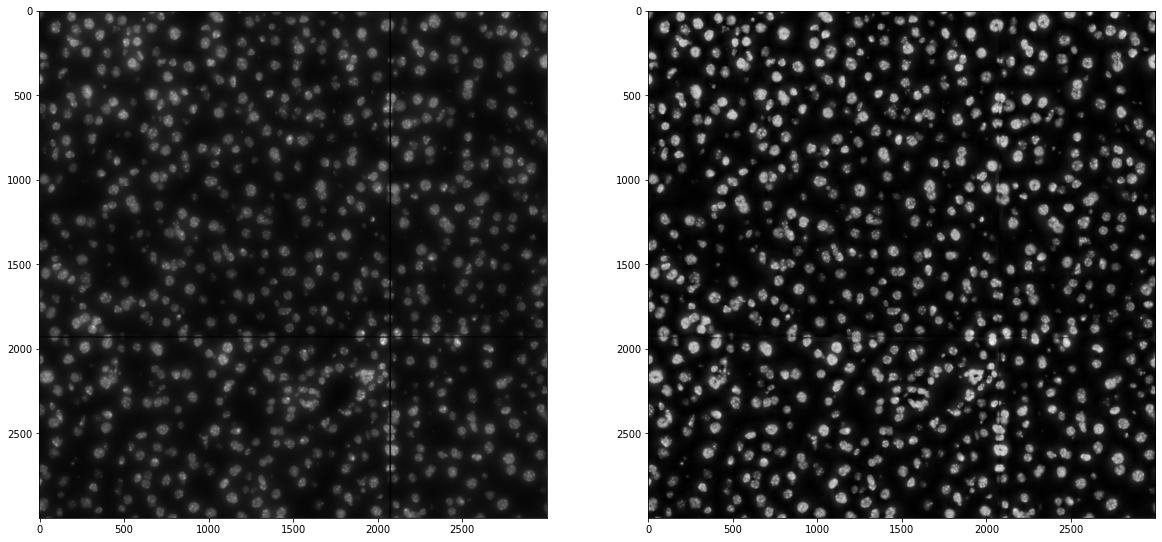

In [ ]:
crd=[4500,7500,6500,9500]
I=pl.preprocessImage(path_image=path_image,size_tophat=45,small_size_vis=crd,contrast_clip=3.5)

2022-06-28 13:51:49,026 [INFO] ** TORCH CUDA version installed and working. **
2022-06-28 13:51:49,027 [INFO] >>>> using GPU
2022-06-28 13:51:49,144 [INFO] ~~~ FINDING MASKS ~~~
2022-06-28 13:52:32,681 [INFO] >>>> TOTAL TIME 43.54 sec


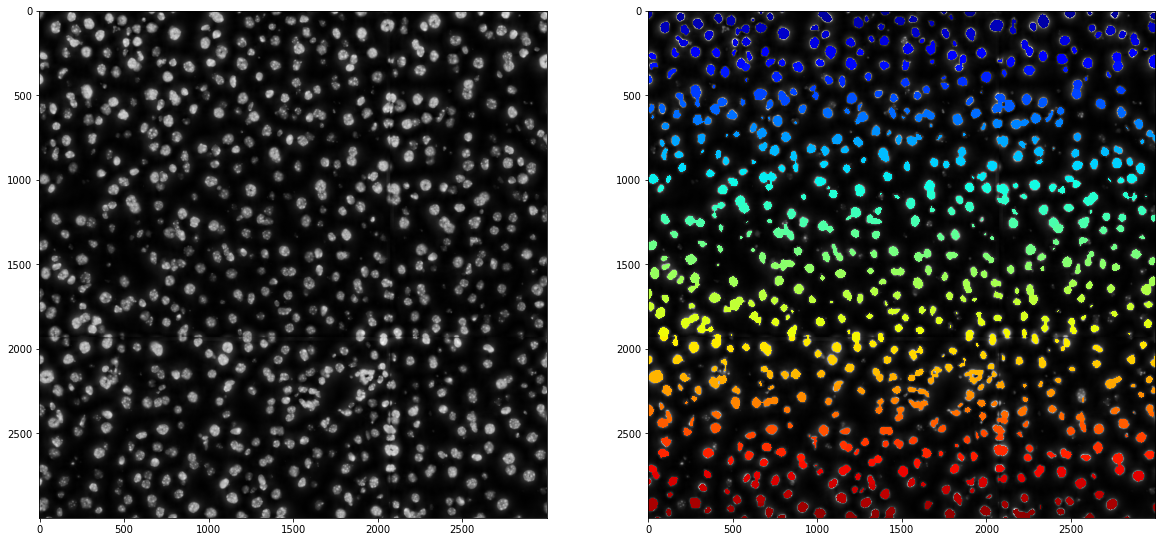

49.32576084136963


In [15]:
Masks=pl.segmentation(I,device='cuda:3',mask_threshold=-1,small_size_vis=crd,flow_threshold=0.7,min_size=1000)

In [85]:
def mask_to_polygons_layer(mask):
    # https://rocreguant.com/convert-a-mask-into-a-polygon-for-images-using-shapely-and-rasterio/1786/
    all_polygons = []
    all_values = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        all_polygons.append(shapely.geometry.shape(shape))
        all_values.append(int(value))
    def color(r):
        return plt.get_cmap("Set1")(np.random.choice(np.arange(0, 18)))

    def border_color(r):
        return plt.get_cmap("tab10")(3) if r else (1, 1, 1 ,1)

    def linewidth(r):
        return 1 if r else 0.5

    def is_in_border(r):
        r = r.centroid
        if (r.x - border_margin < 0) or (r.x + border_margin > h):
            return True
        if (r.y - border_margin < 0) or (r.y + border_margin > w):
            return True
        return False
    polygons=geopandas.GeoDataFrame(dict(geometry=all_polygons), index=all_values)
    border_margin = 30
    w, h = mask.shape[0], mask.shape[1]
    polygons["border"] = polygons.geometry.map(is_in_border)
    polygons["border_color"] = polygons.border.map(border_color)
    polygons["linewidth"] = polygons.border.map(linewidth)
    polygons["color"] = polygons.border.map(color)
    polygons['cells']=polygons.index
    polygons=polygons.dissolve(by='cells')
    polygons["x"] = polygons.centroid.map(lambda p: p.x)
    polygons["y"] = polygons.centroid.map(lambda p: p.y)
    polygons['size']=polygons.area
    return polygons


In [86]:
polygons=mask_to_polygons_layer(Masks)

(6500.0, 9500.0)

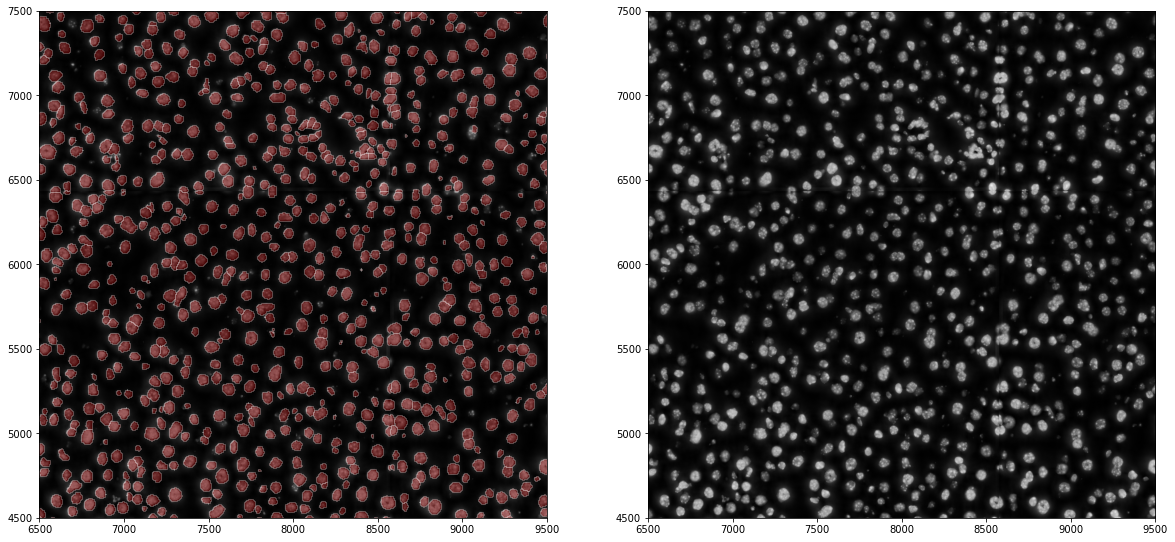

In [89]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(I,cmap='gray')
polygons.plot(ax=ax[0],edgecolor='white',linewidth=polygons.linewidth,alpha=0.5,color='maroon')
ax[1].imshow(I,cmap='gray')
ax[0].set_ylim(crd[0], crd[1])
ax[0].set_xlim(crd[2], crd[3])
ax[1].set_ylim(crd[0], crd[1])
ax[1].set_xlim(crd[2], crd[3])

In [90]:
np.save('/srv/scratch/lottep/RESOLVE/Pipeline_Results/Masks_short/SegmentationMask'+name_slide,Masks)

In [91]:
df=pl.allocate_genes_quick(path_Coordinates,Masks)

In [56]:
df.groupby(['cells']).size()

cells
0        3545281
1             81
2            180
3             43
4            162
          ...   
11307          2
11308          7
11310          1
11311          2
11312          3
Length: 11292, dtype: int64

In [94]:
polygons

geometry  border  \
cells                                                              
1      POLYGON ((8905.000 0.000, 8951.000 0.000, 8951...    True   
2      POLYGON ((9122.000 0.000, 9174.000 0.000, 9174...    True   
3      POLYGON ((9316.000 0.000, 9316.000 13.000, 931...    True   
4      POLYGON ((9520.000 0.000, 9578.000 0.000, 9578...    True   
5      POLYGON ((9672.000 0.000, 9724.000 0.000, 9724...    True   
...                                                  ...     ...   
11308  POLYGON ((2253.000 12855.000, 2282.000 12855.0...    True   
11309  POLYGON ((4013.000 12855.000, 4029.000 12855.0...    True   
11310  POLYGON ((5715.000 12855.000, 5737.000 12855.0...    True   
11311  POLYGON ((6284.000 12855.000, 6304.000 12855.0...    True   
11312  POLYGON ((10196.000 12855.000, 10209.000 12855...    True   

                                            border_color  linewidth  \
cells                                                                 
1      (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
2      (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
3      (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
4      (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
5      (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
...                                                  ...        ...   
11308  (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
11309  (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
11310  (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
11311  (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   
11312  (0.8392156862745098, 0.15294117647058825, 0.15...        1.0   

                                                   color             x  \
cells                                                                    
1      (0.21568627450980393, 0.49411764705882355, 0.7...   8927.800657   
2                                   (0.6, 0.6, 0.6, 1.0)   9147.449113   
3                                   (0.6, 0.6, 0.6, 1.0)   9340.706681   
4      (0.9686274509803922, 0.5058823529411764, 0.749...   9546.668622   
5                                   (0.6, 0.6, 0.6, 1.0)   9696.311196   
...                                                  ...           ...   
11308                               (1.0, 1.0, 0.2, 1.0)   2266.774725   
11309                (1.0, 0.4980392156862745, 0.0, 1.0)   4018.449153   
11310  (0.596078431372549, 0.3058823529411765, 0.6392...   5726.863636   
11311                               (0.6, 0.6, 0.6, 1.0)   6294.000000   
11312                               (0.6, 0.6, 0.6, 1.0)  10203.336364   

                  y    size  
cells                        
1         21.245326  1979.0  
2         29.433992  3439.0  
3          9.897704   958.0  
4         22.826246  2728.0  
5         24.121295  2733.0  
...             ...     ...  
11308  12859.631868   273.0  
11309  12859.855932   177.0  
11310  12859.772727   231.0  
11311  12859.750000   216.0  
11312  12860.045455   165.0  

[11312 rows x 8 columns]

In [121]:
coordinates=df.groupby(['cells']).mean().iloc[:,[0,1]] #calculate the mean of the transcripts for every cell. Now based on transcripts, better on masks? 
#based on masks is present in the adata.obsm

cellCounts=df.groupby(['cells',3]).size().unstack(fill_value=0) #create a matrix based on counts 
adata = AnnData(cellCounts[cellCounts.index!=0])
coordinates.index=coordinates.index.map(str)
adata.obsm['spatial'] = coordinates[coordinates.index!='0']


/srv/scratch/lottep/anaconda3/envs/try/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [122]:
polygonsF=polygons[np.isin(polygons.index.values,list(map(int,adata.obs.index.values)))]
polygonsF.index=list(map(str,polygonsF.index))
adata.obsm['polygons']=polygonsF

In [127]:
adata

AnnData object with n_obs × n_vars = 11291 × 100
    uns: 'spatial'
    obsm: 'spatial', 'polygons'

In [126]:
adata=pl.create_adata_quick(df,I,polygons)

/srv/scratch/lottep/anaconda3/envs/try/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [43]:
adata_nuc=pl.create_adata(df,distances=None,cells,I,filterCrit=0)
#adata=pl.create_adata(df,distances,cells,I,filterCrit=None)

SyntaxError: positional argument follows keyword argument (3519998784.py, line 1)

/srv/scratch/lottep/anaconda3/envs/try/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


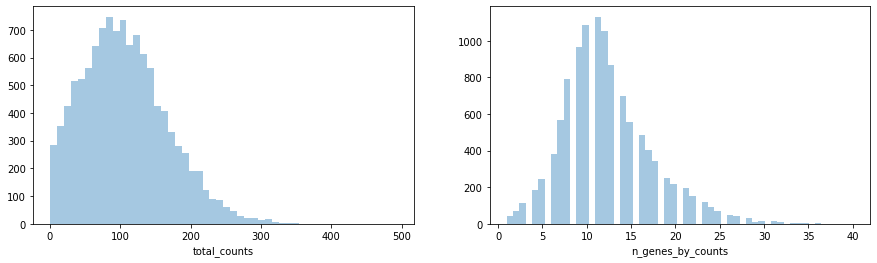

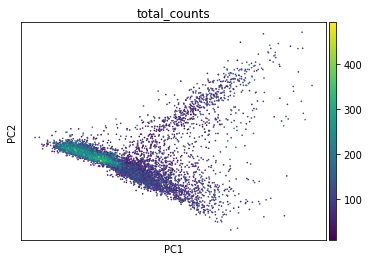

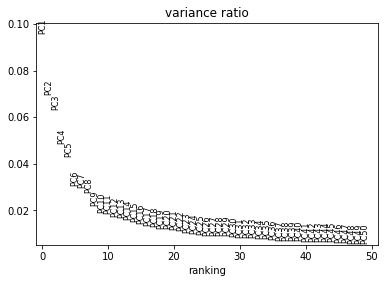

In [128]:
adata=pl.preprocessAdata(adata,Masks)

In [142]:
adata.obsm['spatial']

0             1
cells                           
1      8925.666667     25.604938
2      9147.055556     32.094444
3      9341.953488     12.116279
4      9546.166667     23.796296
5      9693.805369     24.959732
...            ...           ...
11297  6145.333333  12852.166667
11298  7436.187500  12852.500000
11300  8991.666667  12852.466667
11301  9731.428571  12853.619048
11305  2787.900000  12855.300000

[11043 rows x 2 columns]

In [145]:
adata.obsm['polygons'][['x','y']]

x             y
1      8927.800657     21.245326
2      9147.449113     29.433992
3      9340.706681      9.897704
4      9546.668622     22.826246
5      9696.311196     24.121295
...            ...           ...
11297  6147.685484  12854.669355
11298  7441.868613  12854.708029
11300  8987.685185  12856.405350
11301  9725.657186  12856.080838
11305  2788.790323  12858.261290

[11043 rows x 2 columns]

[<AxesSubplot:title={'center':'nucleusSize'}, xlabel='spatial1', ylabel='spatial2'>]

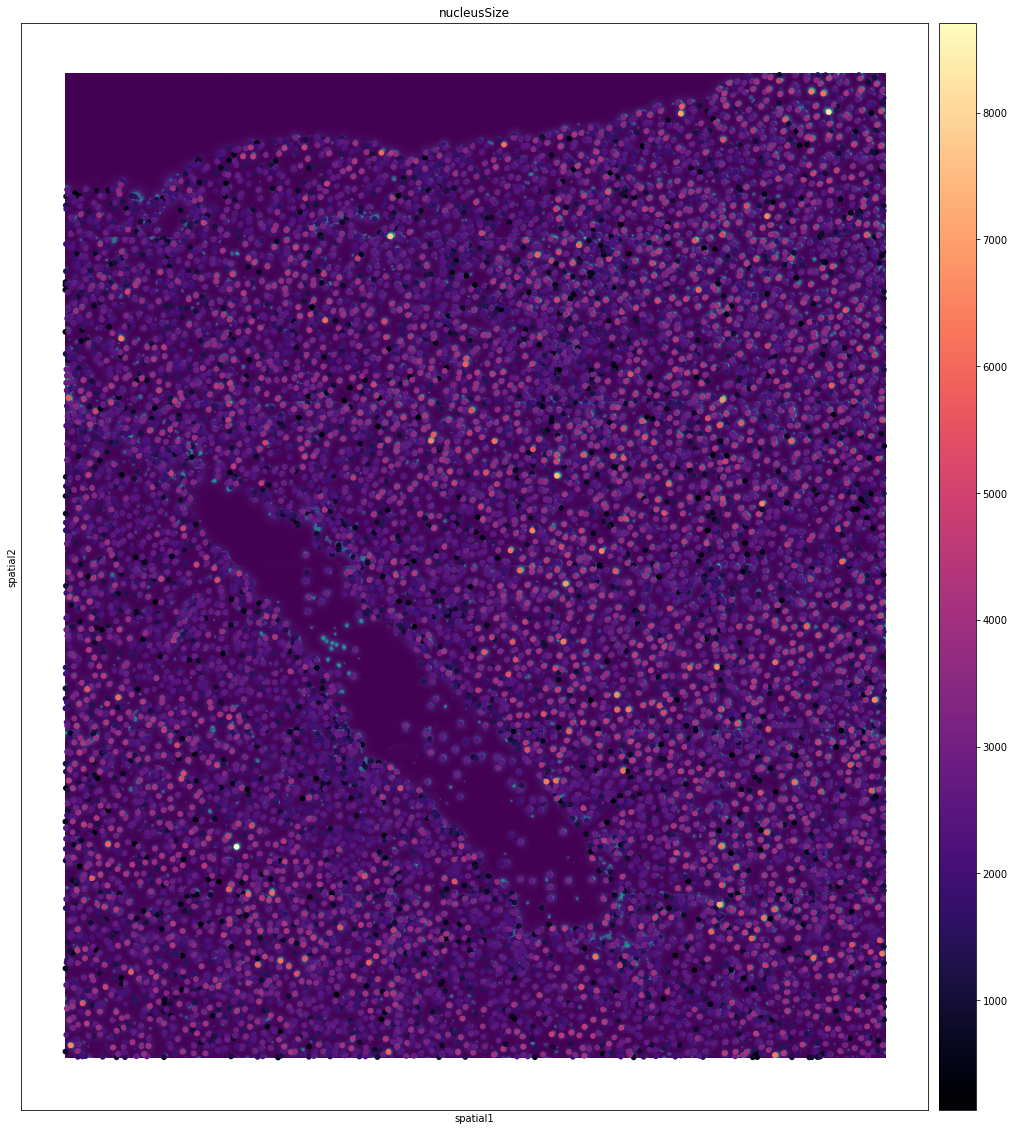

In [135]:
fig,ax =plt.subplots(1,1,figsize=(20,20))
sc.pl.spatial(adata,color='nucleusSize',show=False,cmap='magma',alpha=1,ax=ax)

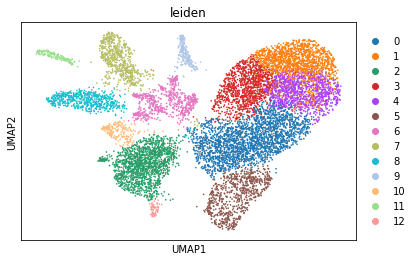

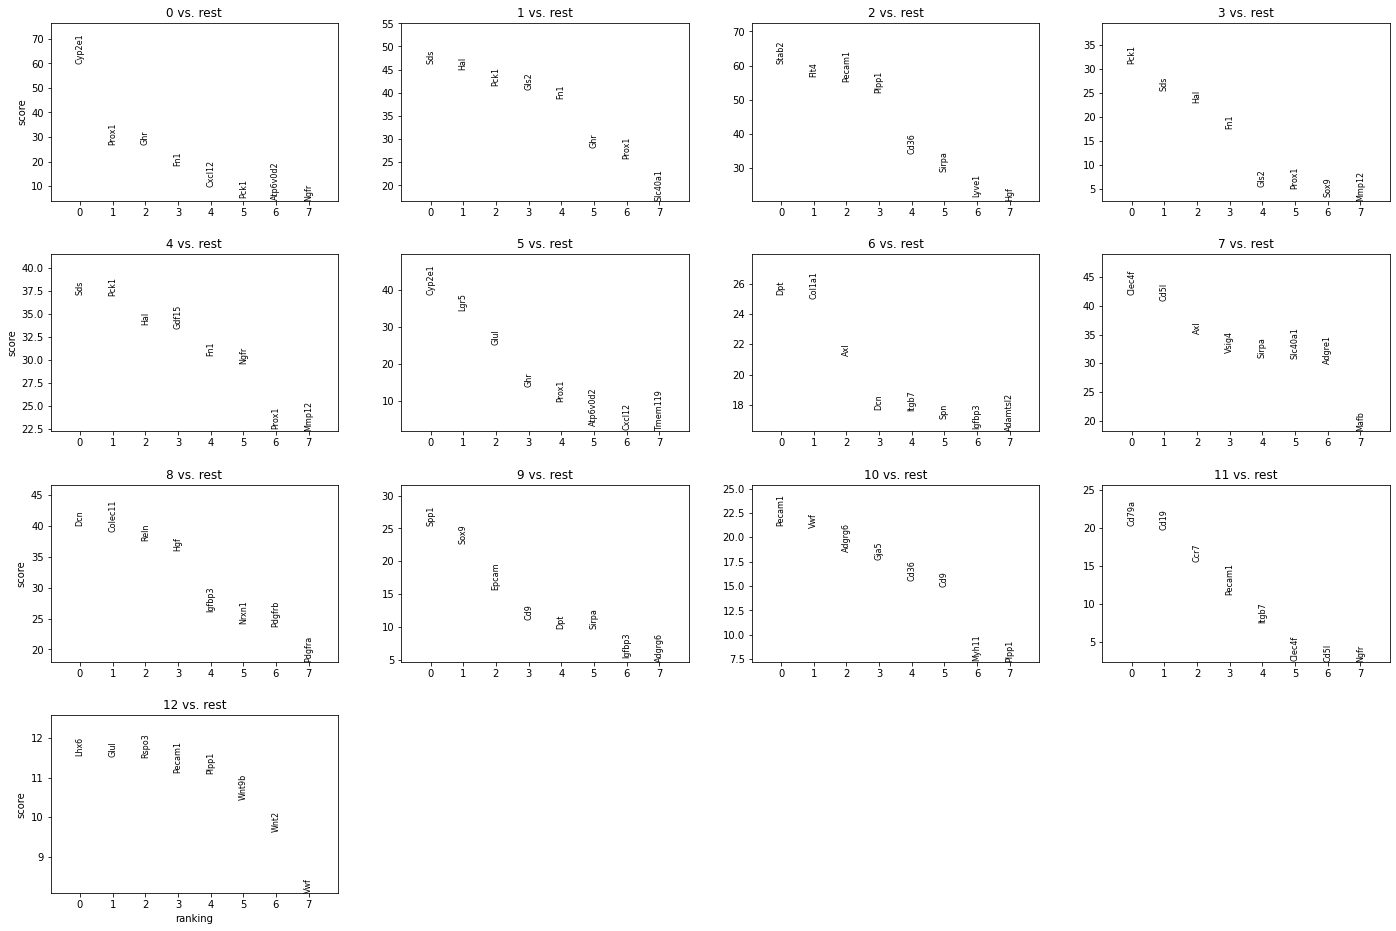

AnnData object with n_obs × n_vars = 11043 × 98
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'nucleusSize', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

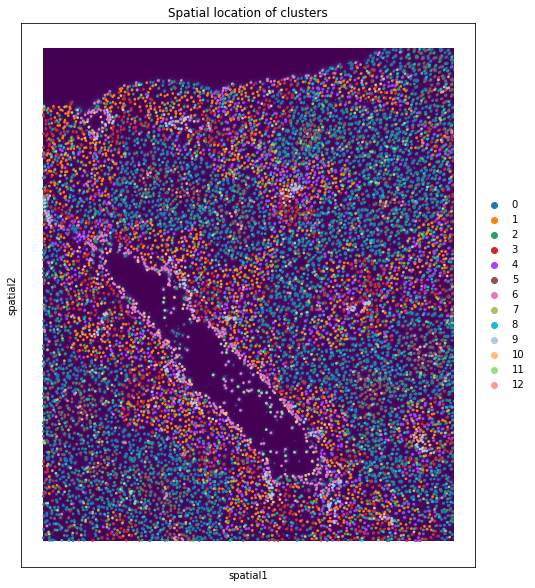

In [15]:
pl.preprocess3(adataNuc,16,30)

/srv/scratch/lottep/anaconda3/envs/try/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'maxScores' as categorical


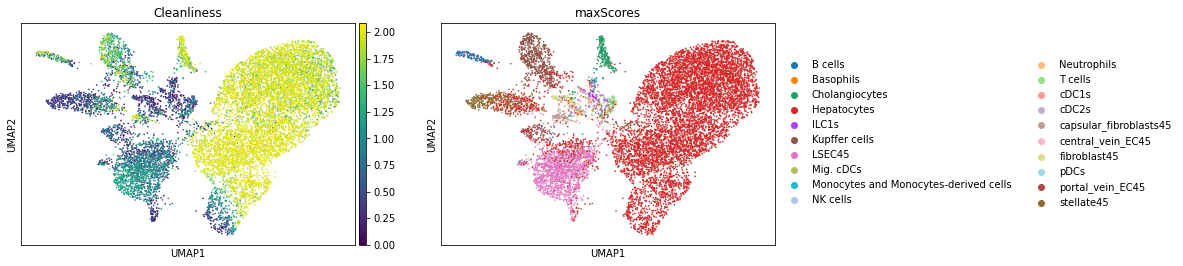

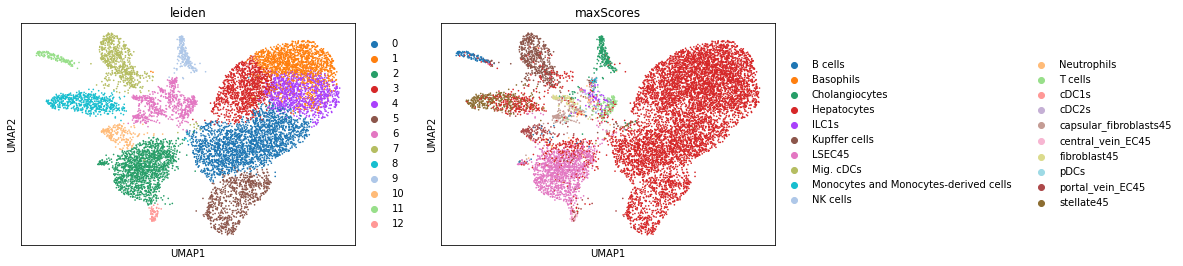

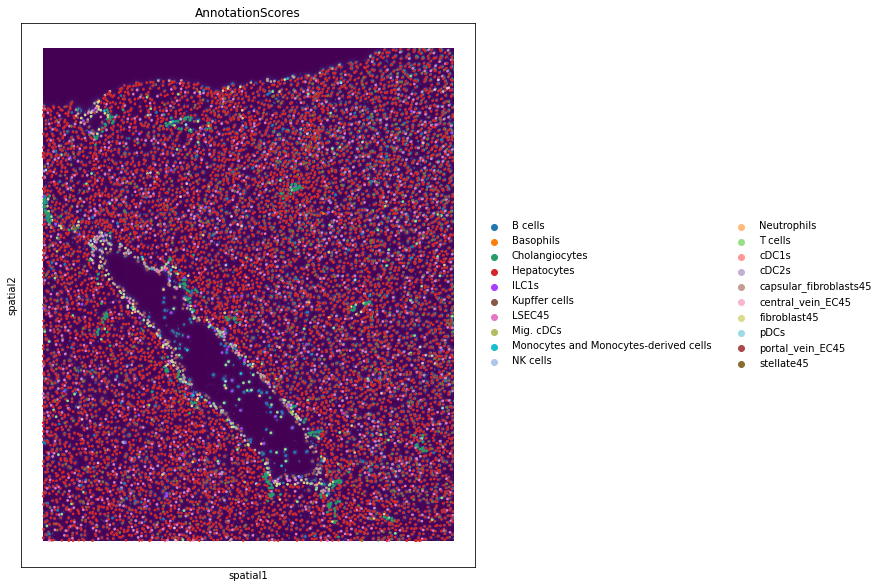

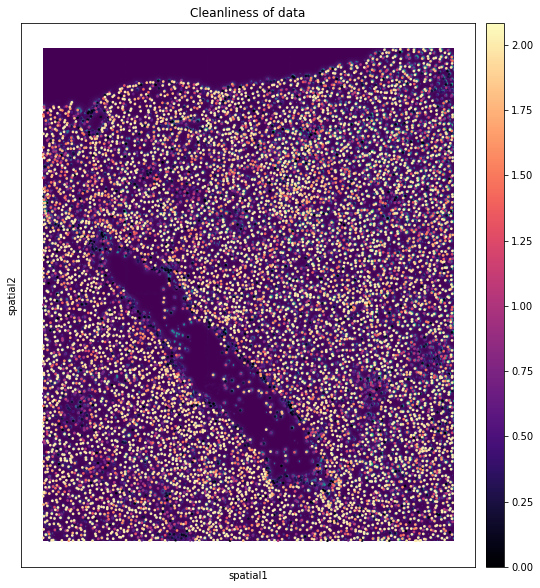

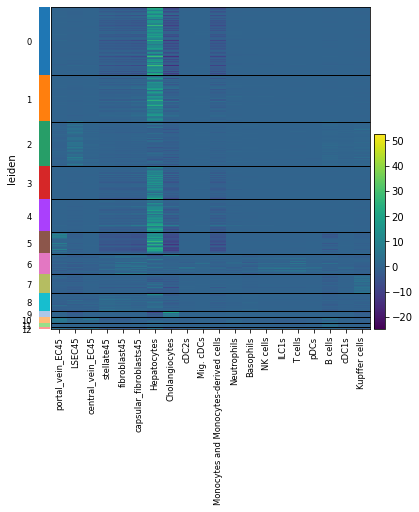

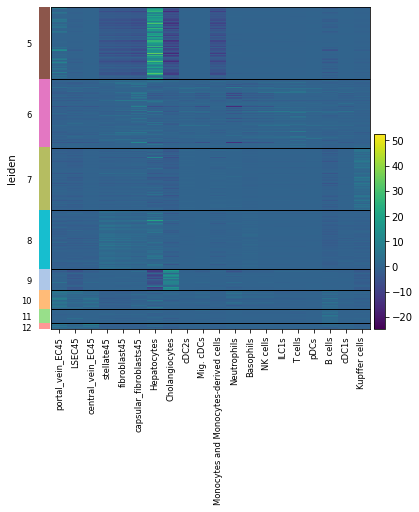

In [31]:
path_MG='/srv/scratch/lottep/LiverMarkerGenes/markers_including_CD45neg.csv'
MGDict=pl.score_genes(adataNuc,path_MG)

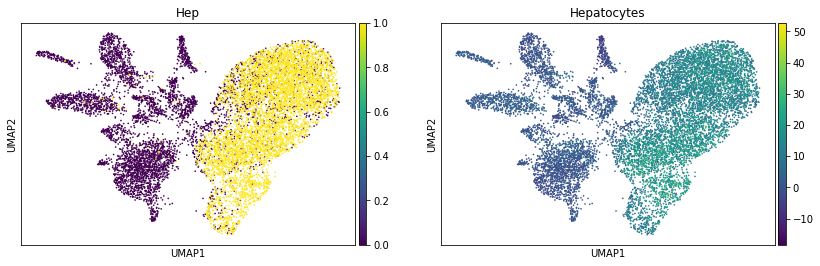

In [32]:
adataNuc.obs['Hep']=(adataNuc.obs['Hepatocytes']>7.6).astype(int)
sc.pl.umap(adataNuc,color=['Hep','Hepatocytes'])

In [33]:
for i in range(0,len(adataNuc.obs)):
    if adataNuc.obs['Hepatocytes'].iloc[i]<7.6:    
        adataNuc.obs['Hepatocytes'].iloc[i]=adataNuc.obs['Hepatocytes'].iloc[i]/7

/srv/scratch/lottep/anaconda3/envs/try/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


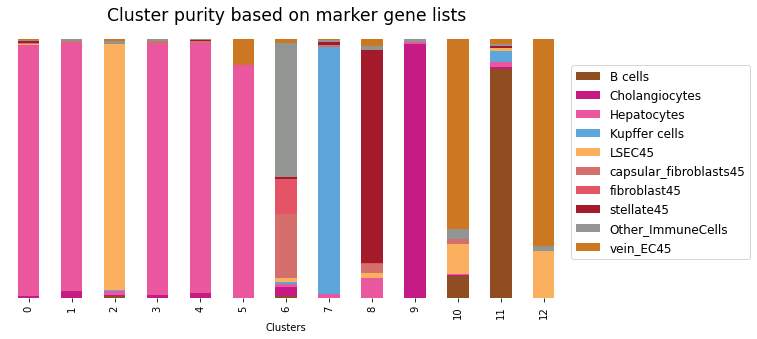

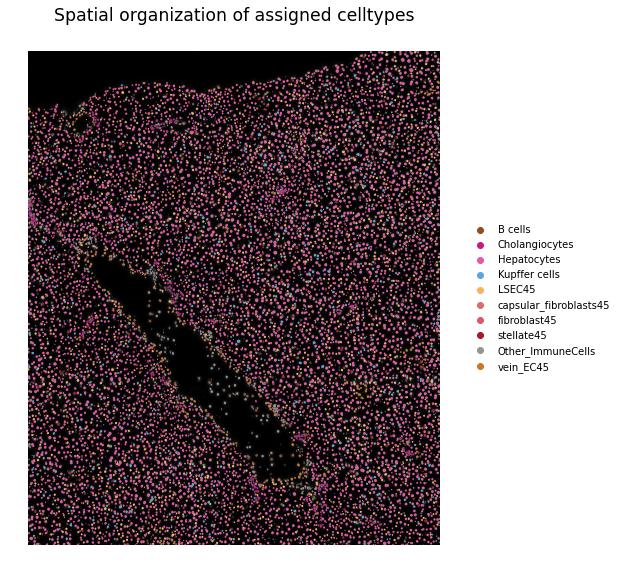

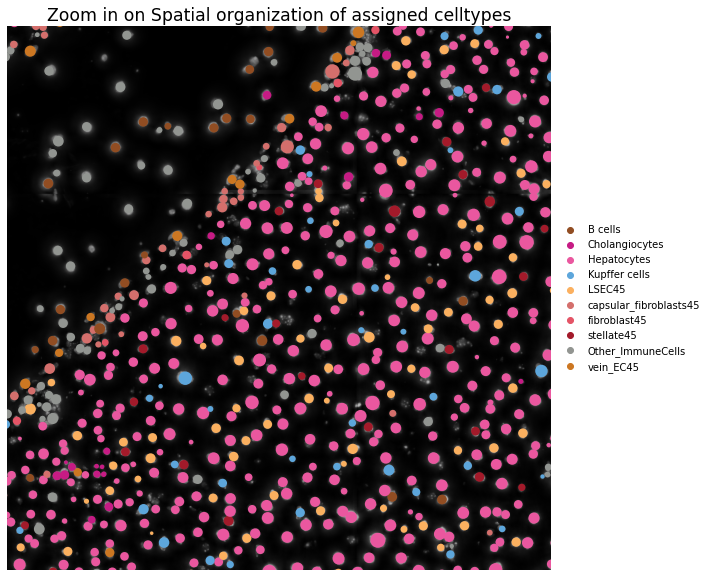

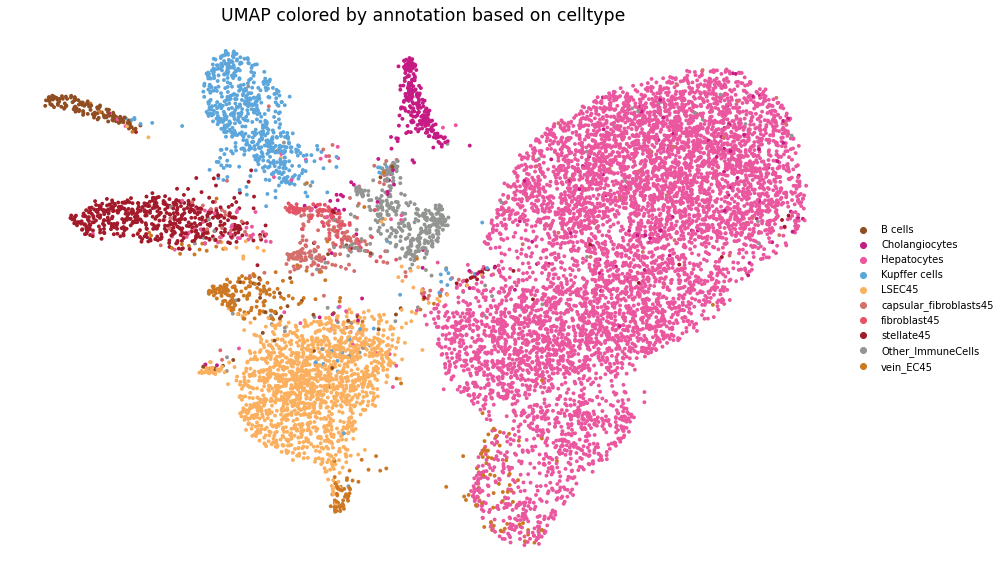

In [34]:
pl.clustercleanliness(adataNuc,I,celltypes=np.array(sorted(list(MGDict.keys()))),crop_coord=crd)

In [29]:
adataNuc.raw.var.index.names=['genes']
adataNuc.var.index.names=['genes']
adataNuc.obsm['spatial']=adataNuc.obsm['spatial'].rename({0: 'X', 1: 'Y'}, axis=1)
#adataNuc.obs['cluster']=[names[int(i)] for i in adataNuc.obs['leiden']]
#adataNuc.obs['cluster']=adataNuc.obs['cluster'].astype("category")

In [35]:
adataNuc.write('/srv/scratch/lottep/RESOLVE/Pipeline_Results/adataFilesShort/adataNuc'+name_slide+'.h5ad')

  0%|          | 0/1000 [00:00<?, ?/s]

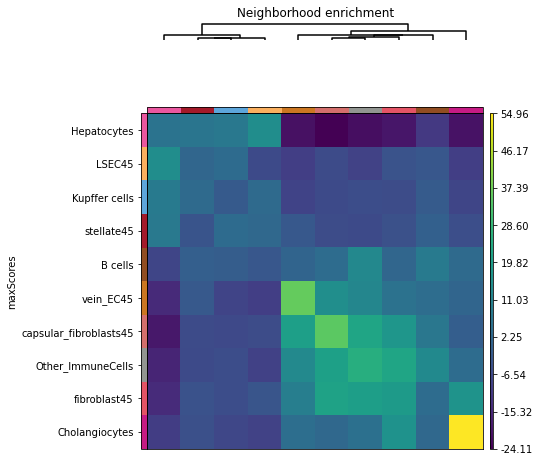

In [36]:
sq.gr.spatial_neighbors(adataNuc, coord_type="generic")
sq.gr.nhood_enrichment(adataNuc, cluster_key="maxScores")
sq.pl.nhood_enrichment(adataNuc, cluster_key="maxScores", method="ward")

In [ ]:
adataNuc.obs['cluster']

In [ ]:
from tifffile import imsave
imsave('/srv/scratch/lottep/RESOLVE/Pipeline_Results/adataFilesShort/adataNuc'+name_slide+'.tif',I)

In [28]:
len(adataNuc.obs.maxScoresSave.cat.categories)

19

In [47]:
adataNuc

AnnData object with n_obs × n_vars = 11043 × 98
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'nucleusSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'central_vein_EC45', 'stellate45', 'fibroblast45', 'capsular_fibroblasts45', 'Hepatocytes', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Monocytes and Monocytes-derived cells', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Cleanliness', 'maxScores', 'Hep', 'maxScoresSave'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'maxScores_colors', 'spatial_neighbors', 'maxScores_nhood_enrichment'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distance